# Cosmic-ray flux vs. sky position

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import division, print_function
import os
import sys
from numbers import Number
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.array as da
import pyunfold

import comptools as comp
import sky_anisotropy as sa

color_dict = comp.color_dict

%matplotlib inline

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [5]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [6]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
#                                           energy_reco=True,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

[########################################] | 100% Completed |  6.6s


In [7]:
feature_list, feature_labels = comp.get_training_features()

In [8]:
print('Running energy reconstruction...')
energy_pipeline = comp.load_trained_model('RF_energy_{}'.format(config))
for df in [df_sim_train, df_sim_test]:
    X = df_sim_train[feature_list].values
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [9]:
# Load fitted efficiencies and calculate effective areas
# eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
#                         'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
eff_path = comp.get_efficiencies_file(config=config,
                                      num_groups=num_groups,
                                      sigmoid='slant')
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007118,0.000082,0.000083,0.006394,0.000082,0.000082,0.006734,0.000061,0.000057
1,0.007923,0.000069,0.000072,0.007471,0.000062,0.000063,0.007682,0.000049,0.000049
2,0.008372,0.000066,0.000060,0.008010,0.000065,0.000057,0.008192,0.000047,0.000045
3,0.008605,0.000068,0.000062,0.008274,0.000067,0.000061,0.008455,0.000047,0.000048
4,0.008733,0.000069,0.000061,0.008422,0.000063,0.000062,0.008602,0.000045,0.000049


In [14]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.max(np.pi * thrown_radii**2)
thrown_area

9079202.768874502

In [15]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [16]:
efficiencies

array([0.00711839, 0.0063939 , 0.00792342, 0.00747082, 0.00837221,
       0.0080099 , 0.008605  , 0.00827364, 0.0087326 , 0.00842248,
       0.00880584, 0.00853154, 0.00885625, 0.00862469, 0.00889662,
       0.00870939, 0.0089316 , 0.00879194, 0.00896487, 0.00887237,
       0.00899603, 0.00895298, 0.00902592, 0.00903645, 0.00905475,
       0.00911802, 0.00908371, 0.00919968, 0.00911568, 0.00928121,
       0.00914495, 0.00936215, 0.00917547, 0.00944462, 0.00920386,
       0.00952653, 0.00923482, 0.00960895])

In [17]:
print('Running composition classifications...')
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


/home/jbourbeau/cr-composition/comptools/data_functions.py:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)


In [20]:
np.testing.assert_allclose(response.sum(axis=0), efficiencies)

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


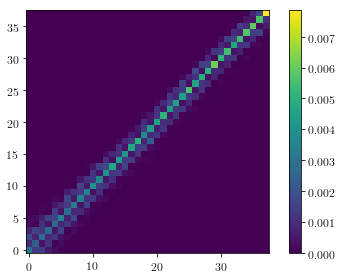

In [21]:
plt.imshow(response, origin='lower')
plt.colorbar()
plt.show()

In [22]:
print('Loading data into memory...')
df_data = comp.load_data(config=config,
                         energy_reco=True,
                         log_energy_min=6.1,
                         log_energy_max=8.0,
                         columns=feature_list + ['lap_ra', 'lap_dec'],
                         n_jobs=20,
                         verbose=True)

Loading data into memory...
[########################################] | 100% Completed |  2min 58.7s


In [23]:
df_data.shape

(6668215, 7)

In [24]:
energybins.log_energy_bins

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

In [25]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.100001266909608, 7.979532177403555)

### Data declination distribution

In [26]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [27]:
dec_median = df_data.loc[:, 'lap_dec'].median()
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.30927265203 [rad]
dec_median = -75.0157971934 [deg]


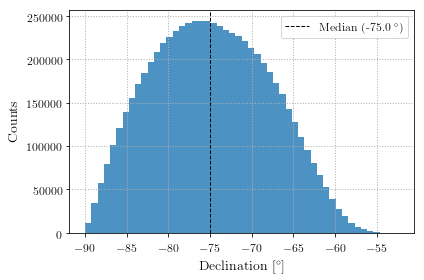

In [28]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

### Flux vs. declination 

In [23]:
import dask.array as da

X_data = da.from_array(df_data[feature_list].values, chunks=int(1e4))
X_data

dask.array<array, shape=(6668215, 3), dtype=float64, chunksize=(10000, 3)>

In [24]:
from dask_ml.wrappers import ParallelPostFit
from dask.diagnostics import ProgressBar

pred_comp_target = ParallelPostFit(comp_pipeline).predict(X_data)
reco_log_energy = ParallelPostFit(energy_pipeline).predict(X_data)

In [25]:
with ProgressBar():
    print('Running energy reconstructions...')
    df_data['reco_log_energy'] = reco_log_energy.compute(schuduler='threads', 
                                                         num_workers=20)
    print('Running composition classifications...')
    df_data['pred_comp_target'] = pred_comp_target.compute(schuduler='threads', 
                                                           num_workers=20)

Running energy reconstructions...
[########################################] | 100% Completed | 49.1s
Running composition classifications...
[#                                       ] | 4% Completed |  0.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###                                     ] | 9% Completed |  0.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####                                   ] | 13% Completed |  0.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#######                                 ] | 18% Completed |  1.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#########                               ] | 23% Completed |  1.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###########                             ] | 28% Completed |  1.5s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#############                           ] | 33% Completed |  1.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###############                         ] | 38% Completed |  1.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#################                       ] | 43% Completed |  2.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################                     ] | 47% Completed |  2.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####################                    ] | 52% Completed |  2.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[######################                  ] | 56% Completed |  2.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[########################                ] | 60% Completed |  3.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##########################              ] | 65% Completed |  3.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[############################            ] | 70% Completed |  3.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#############################           ] | 74% Completed |  3.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###############################         ] | 79% Completed |  3.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#################################       ] | 84% Completed |  4.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################################     ] | 88% Completed |  4.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####################################   ] | 93% Completed |  4.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####################################### ] | 98% Completed |  4.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[########################################] | 100% Completed |  4.8s


/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

In [25]:
# print('Running energy and composition reconstructions...')
# df_data['pred_comp_target'] = comp_pipeline.predict(df_data[feature_list].values)
# df_data['reco_log_energy'] = energy_pipeline.predict(df_data[feature_list].values)

In [26]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area
    
# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [27]:
np.rad2deg(np.arccos(df_data.lap_cos_zenith.max())), np.rad2deg(np.arccos(df_data.lap_cos_zenith.min()))

(0.0048982721856552, 37.65427444520522)

In [28]:
def calc_solid_angle(theta_min=0, theta_max=np.pi/2):
    return 2*np.pi*(np.cos(theta_min) - np.cos(theta_max))

def calc_geom_factor(theta_min=0, theta_max=np.pi/2):
    return (np.cos(theta_min) + np.cos(theta_max)) / 2

In [29]:
efficiencies

array([0.00711839, 0.0063939 , 0.00792342, 0.00747082, 0.00837221,
       0.0080099 , 0.008605  , 0.00827364, 0.0087326 , 0.00842248,
       0.00880584, 0.00853154, 0.00885625, 0.00862469, 0.00889662,
       0.00870939, 0.0089316 , 0.00879194, 0.00896487, 0.00887237,
       0.00899603, 0.00895298, 0.00902592, 0.00903645, 0.00905475,
       0.00911802, 0.00908371, 0.00919968, 0.00911568, 0.00928121,
       0.00914495, 0.00936215, 0.00917547, 0.00944462, 0.00920386,
       0.00952653, 0.00923482, 0.00960895])

light
heavy


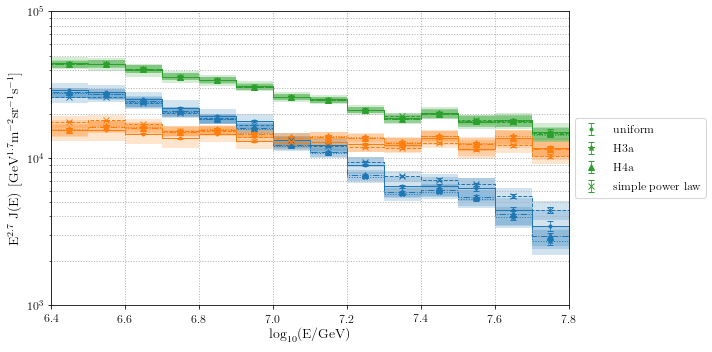

In [82]:
filenames = ['allsky.png']
# filenames = ['dec_lt_median.png', 'dec_gt_median.png', 'allsky.png']
theta_lims = [(0, 90)]

for filename, (theta_min, theta_max) in zip(filenames, theta_lims):

    # Solid angle
#     theta_max = 40 if config == 'IC79.2010' else 65
    solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2
#     solid_angle = calc_solid_angle(theta_min=theta_min, theta_max=theta_max)
    geom_factor = calc_geom_factor(theta_min=theta_min, theta_max=theta_max)
    geom_factor = 1

    def counts_to_flux(counts, counts_err=None, composition=None):
        return comp.get_flux(counts, counts_err,
                             energybins=energybins.energy_bins,
                             eff_area=thrown_area,
                             eff_area_err=None,                            
#                              eff_area=geom_factor * eff_area[composition],
#                              eff_area_err=geom_factor * eff_area_err[composition],
                             livetime=livetime,
                             livetime_err=livetime_err,
                             solid_angle=solid_angle,
                             scalingindex=2.7)


    counts_observed = {}
    counts_observed_err = {}

#     dec_mask = df_data['lap_dec'] < dec_median
    dec_mask = np.ones(df_data.shape[0], dtype=bool)

    for idx, composition in enumerate(comp_list):
        print(composition)
        # Filter out events that don't pass composition & energy mask
        pred_comp_mask = df_data['pred_comp_target'] == idx

        mask = np.logical_and(pred_comp_mask, dec_mask)
    #     df_data = df_data.loc[df_data, :]
    #     print(mask)
    #     print(pred_comp_mask.sum())

        energies = df_data.loc[mask, 'reco_log_energy'].values
        comp_counts, _ = np.histogram(energies,
                                      bins=energybins.log_energy_bins)
        counts_observed[composition] = comp_counts
        counts_observed_err[composition] = np.sqrt(comp_counts)

    counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
    # Calculate total counts
    counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

    # Format observed counts, detection efficiencies, and priors for PyUnfold use
    counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    for idx, composition in enumerate(comp_list):
        counts_pyunfold[idx::num_groups] = counts_observed[composition]
        counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]


    # Run unfolding for each of the priors
    names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
    # names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
    unfolding_results = {}
    for prior_name in names:
        prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
        # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
        df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                      data_err=counts_err_pyunfold,
                                                      response=response,
                                                      response_err=response_err,
                                                      efficiencies=efficiencies,
                                                      efficiencies_err=efficiencies_err,
                                                      ts='ks',
                                                      ts_stopping=0.005,
                                                      prior=prior,
                                                      return_iterations=True)
    #                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=3, smooth=1)])
        unfolding_results[prior_name] = df_unfolding_iter



    fig, ax = plt.subplots(figsize=(10, 5))
    linestyles = ['-', ':', '-.', '--']
    markers = ['.', '*', '^', 'x']
    for prior_name, ls, marker in zip(names, linestyles, markers):
        counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                            num_groups=num_groups)
        for composition in comp_list + ['total']:
            flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                                counts_err=counts_sys_err[composition],
                                                composition=composition)
            flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                                 counts_err=counts_stat_err[composition],
                                                 composition=composition)
            comp.plot_steps(energybins.log_energy_bins, 
                            flux,
                            yerr=flux_sys_err,
                            color=color_dict[composition],
                            ls=ls,
                            ax=ax)
            label = prior_name.replace('_', ' ') if composition == 'total' else ''
            ax.errorbar(energybins.log_energy_midpoints, flux,
                        yerr=flux_stat_err,
                        color=color_dict[composition],
                        ls='None',
                        marker=marker,
                        label=label)
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e3, 1e5)
    ax.grid(lw=1, which='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
    outfile = os.path.join(comp.paths.figures_dir, 'skymaps', filename)
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_lt_median.png')
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_gt_median.png')
    comp.check_output_dir(outfile)
#     plt.savefig(outfile)
    plt.show()

## Cosmic-ray flux vs. sky position

In [29]:
nside = 64
npix = hp.nside2npix(nside)
radius = np.deg2rad(5)

In [156]:
def equatorial_to_healpy(ra, dec):
    """Converts equatorial coordinates (ra, dec) to healpy coordinates (theta, phi)
    
    Parameters
    ----------
    ra : float, array_like
        Right ascension coordinates in radians. 
    dec : float, array_like
        Declination coordinates in radians. 
    
    Returns
    -------
    theta : float, array_like
        Healpy theta coordinates in radians.
    phi : float, array_like
        Healpy phi coodinates in radians.
    """
    theta = np.pi/2 - dec
    phi = ra

    return theta, phi


def healpy_to_equatorial(theta, phi):
    """Converts healpy coordinates (theta, phi) to equatorial coordinates (ra, dec)
    
    Parameters
    ----------
    theta : float, array_like
        Healpy theta coordinates in radians.
    phi : float, array_like
        Healpy phi coodinates in radians.
    
    Returns
    -------
    ra : float, array_like
        Right ascension coordinates in radians. 
    dec : float, array_like
        Declination coordinates in radians. 
    """
    dec = np.pi/2 - theta
    ra = phi

    return ra, dec

In [30]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values
# Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in healpy
theta, phi = comp.equatorial_to_healpy(ra, dec)

In [31]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [32]:
df_data['pix'] = pix_array

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


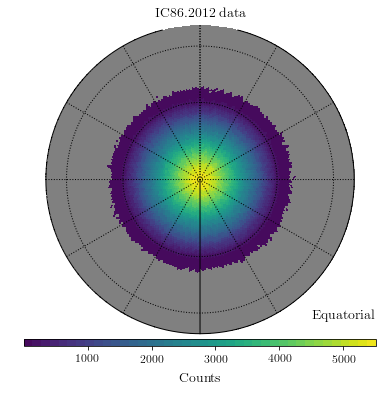

In [33]:
data_skymap[data_skymap == 0] = hp.UNSEEN
comp.plot_skymap(data_skymap, cbar_title='Counts', polar=True)
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-data-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [34]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [35]:
ra_test = np.deg2rad(72)
dec_test = np.deg2rad(-80)

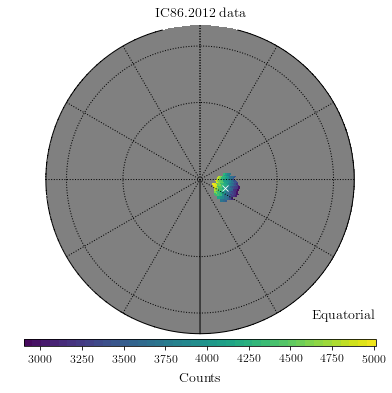

In [37]:
theta_test, phi_test = sa.equatorial_to_healpy(ra_test, dec_test)
vec = hp.ang2vec(theta_test, phi_test)
ipix = hp.query_disc(nside, vec=vec, radius=radius)
in_disc = np.isin(np.arange(npix), ipix)
on_disc_skymap = data_skymap.copy()
on_disc_skymap[~in_disc] = hp.UNSEEN

on_disc_skymap[on_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(on_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-on-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

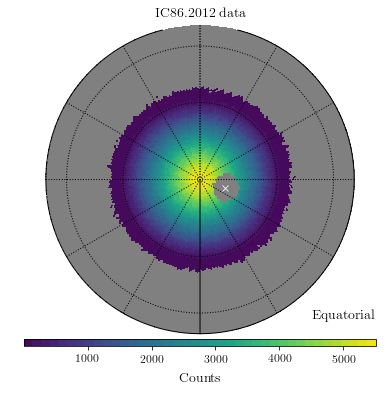

In [38]:
off_disc_skymap = data_skymap.copy()
off_disc_skymap[in_disc] = hp.UNSEEN

off_disc_skymap[off_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(off_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-off-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [39]:
theta, phi = sa.equatorial_to_healpy(df_data.loc[:, 'lap_ra'].values,
                                     df_data.loc[:, 'lap_dec'].values)
pix_idx = hp.ang2pix(nside=nside, theta=theta, phi=phi)
in_disc = np.isin(pix_idx, ipix)

# ebins = np.arange(6.4, 7.9, 0.1)
ebins = np.arange(6.4, 7.5, 0.1)
ebins = np.concatenate([ebins, [7.8]])

energies_in_disc = df_data.loc[in_disc, 'reco_log_energy'].values
counts_in_disc, _ = np.histogram(energies_in_disc, bins=ebins) 
print('counts_in_disc = {}'.format(counts_in_disc))

energies_outside_disc = df_data.loc[~in_disc, 'reco_log_energy'].values
counts_outside_disc, _ = np.histogram(energies_outside_disc, bins=ebins)
print('counts_outside_disc = {}'.format(counts_outside_disc))

counts_in_disc = [34462 27960 18223 13115  6330  3890  1990  1548   776   653   861]
counts_outside_disc = [674297 512734 329631 212497 115362  81034  36118  25953  15927  10945
  15860]


In [40]:
ebins

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.8])

In [41]:
assert counts_in_disc.shape == counts_outside_disc.shape

alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
print('alpha = {}'.format(alpha))
expected = alpha * counts_outside_disc
# expected = 1 * counts_outside_disc

# assert np.allclose(counts_in_disc.sum(), expected.sum())

chi_squared_likelihood = 2 * np.sum(expected - counts_in_disc + (counts_in_disc * np.log(counts_in_disc / expected)))
print('chi_squared_likelihood = {}'.format(chi_squared_likelihood))

chi_squared_on = np.sum((counts_in_disc - expected)**2 / counts_in_disc)
print('chi_squared_on = {}'.format(chi_squared_on))

chi_squared_off = np.sum((counts_in_disc - expected)**2 / expected)
print('chi_squared_off = {}'.format(chi_squared_off))

alpha = 0.0540830730344
chi_squared_likelihood = 430.818468803
chi_squared_on = 420.90663922
chi_squared_off = 437.092560618


In [44]:
# in_energy_range = np.logical_and(energybins.log_energy_midpoints <= 7.8,
#                                  energybins.log_energy_midpoints >= 6.4)

# fig, ax = plt.subplots()
# ax.errorbar(energybins.log_energy_midpoints[in_energy_range], counts_in_disc,
#             yerr=np.sqrt(counts_in_disc),
#             label='Inside disc (on)')
# alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
# expected = alpha * counts_outside_disc
# ax.errorbar(energybins.log_energy_midpoints[in_energy_range], expected,
#             yerr=np.sqrt(expected),
#             label='Outside disc (off)')
# ax.set_yscale('log', nonposy='clip')
# ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
# ax.set_ylabel('Counts')
# ax.set_title('(ra, dec) = ({:0.2f}, {:0.2f})'.format(np.rad2deg(ra_test), np.rad2deg(dec_test)))
# # ax.set_title('$\mathrm{\\chi^2 / d.o.f} = $ '+'{:0.2f}'.format(test_chi2))

# likelihood_str = '$\mathrm{\chi^2_{likelihood}}$' + ' = {:0.1f}'.format(chi_squared_likelihood)
# on_str = '$\mathrm{\chi^2_{on}}$' + ' = {:0.1f}'.format(chi_squared_on)
# off_str = '$\mathrm{\chi^2_{off}}$' + ' = {:0.1f}'.format(chi_squared_off)
# title = '\n'.join([likelihood_str, on_str, off_str])

# # ax.annotate(title, (7.45, 1e4))

# ax.set_xlim(6.4, 7.8)
# ax.grid()
# ax.legend()
# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        '{}-energy-dist-comparison.png'.format(config))
# # plt.savefig(outfile)
# plt.show()

In [74]:
%load_ext line_profiler

In [53]:
from scipy.special import erfcinv
from scipy import stats

def counts_chi_squared(counts_on, counts_off):
    """Calculates reduced chi-squared between two energy histograms

    Parameters
    ----------
    counts_on : numpy.ndarray
        Energy distribution inside disc.
    counts_off : numpy.ndarray
        Energy distribution outside disc. Note that counts_off should be scaled
        to have the same total number of counts as counts_on.

    Returns
    -------
    chi_squared : float
        Chi-squared between two input distributions.
    """
    assert counts_on.shape == counts_off.shape
    assert np.allclose(np.sum(counts_on),
                               np.sum(counts_off))
    chi_squared = 2 * np.sum(counts_off - counts_on + (counts_on * np.log(counts_on / counts_off)))
    return chi_squared


# TODO: remove counts_chi_squared_on and counts_chi_squared_off in the future
def counts_chi_squared_on(counts_on, counts_off):
    assert counts_on.shape == counts_off.shape
    chi_squared = np.sum((counts_on - counts_off)**2 / counts_on)
    return chi_squared


def counts_chi_squared_off(counts_on, counts_off):
    assert counts_on.shape == counts_off.shape
    chi_squared = np.sum((counts_on - counts_off)**2 / counts_off)
    return chi_squared


In [151]:
def disc_chi_squared(values, pix, pix_disc, radius=np.deg2rad(10), nside=64,
                     theta_band=False, bins=None, n_jobs=1, verbose=True):
    """Calculates chi-squared between an on and off region on the sky

    Parameters
    ----------
    values : array_like
        Input values to be
    pix : array_like
        Corresponding healpix pixel for each value in values.
    pix_disc : int, array_like
        Healpix pixels on which to center on region discs.
    radius : float, optional
        Radius (in radians) of on region disc on sky (default is 0.17 radians,
        or 10 degrees).
    nside : float, optional
        Number of sides used for healpix map (default is 64).
    theta_band : bool, optional
        Option to use full sky off region, or restrict the off region to be
        within the same theta band of the on region (default is False,
        will use full sky off region).
    bins : array_like, optional
        Bin edges to use when making binned values disbtritutions (default is
        numpy.linspace(values.min(), values.max(), 20)).
    n_jobs : int, optional
        Number of jobs to run in parallel (default is 1).
    verbose : bool, optional
        Option for verbose output (default is True).

    Returns
    -------
    result : pandas.DataFrame
        DataFrame with information about the distribution comparison between
        the on and off regions.
    """
    values = np.asarray(values)
    pix = np.asarray(pix)
    if values.shape != pix.shape:
        raise ValueError('values and pix must have the same shape, but got '
                         '{} and {}'.format(values.shape, pix.shape))
    if isinstance(pix_disc, Number):
        pix_disc = [pix_disc]
    records = [delayed(disc_chi_squared_single)(values, pix, pix_disc=p, 
                                                radius=radius, nside=nside,
                                                theta_band=theta_band, bins=bins) 
               for p in pix_disc]
    results = delayed(pd.DataFrame.from_records)(records)
    scheduler = 'threads' if n_jobs > 1 else 'sync'
    if verbose:
        sys.stdout.write('Calculating chi-squared for {} regions\n'.format(len(pix_disc)))
        with ProgressBar():
            results = results.compute(scheduler=scheduler, num_workers=n_jobs)
    else:
        results = results.compute(scheduler=scheduler, num_workers=n_jobs)
        
    return results


def disc_chi_squared_single(values, pix, pix_disc, radius=np.deg2rad(10), nside=64,
                            theta_band=False, bins=None):
    vec_disc = hp.pix2vec(nside=nside, ipix=pix_disc)
    pix_in_disc = hp.query_disc(nside=nside, vec=vec_disc, radius=radius)
    in_on_region = np.isin(pix, pix_in_disc)
    if not np.sum(in_on_region):
        raise ValueError('No events found in disc centered at pixel {} with '
                         'radius {}'.format(pix_disc, radius))

    # Construct off region mask
    if not theta_band:
        in_off_region = ~in_on_region
    else:
        theta_in_disc, _ = hp.pix2ang(nside=nside, ipix=pix_in_disc)
        pix_theta_band = hp.query_strip(nside=nside,
                                        theta1=theta_in_disc.min(),
                                        theta2=theta_in_disc.max())
        pix_off_region = np.setdiff1d(pix_theta_band, pix_in_disc)
        in_off_region = np.isin(pix, pix_off_region)

    # Energy distribution inside and outside of disc
    if bins is None:
        bins = np.linspace(values.min(), values.max(), 20)
    counts_in_disc, _ = np.histogram(values[in_on_region], bins=bins)
    counts_outside_disc, _ = np.histogram(values[in_off_region], bins=bins)
    
    if np.isin([counts_in_disc, counts_outside_disc], 0).any():
        raise ValueError('Energy distribution has zero counts in a bin')

    # Want to make sure off region histogram is scaled to the on region histogram
    alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
    scaled_counts_outside_disc = alpha * counts_outside_disc

    # Calculate chi-squared, p-value, and significance
    chi_squared = counts_chi_squared(counts_in_disc, scaled_counts_outside_disc)
    ndof = len(bins) - 1
    pval = stats.chi2.sf(chi_squared, ndof)
    sig = erfcinv(2 * pval) * np.sqrt(2)

    result = {'pix_disc': pix_disc,
              'alpha': alpha,
              'num_on':  np.sum(counts_in_disc),
              'chi2-likelihood': chi_squared,
              'chi2-on': counts_chi_squared_on(counts_in_disc,
                                               scaled_counts_outside_disc),
              'chi2-off': counts_chi_squared_off(counts_in_disc,
                                                 scaled_counts_outside_disc),
              'pval': pval,
              'sig': sig,
              }

    return result


In [152]:
# def disc_chi_squared(data, ra_disc, dec_disc, radius=np.deg2rad(10),
#                      nside=64, dec_band=False, energy_bins=None):
#     """Calculates energy spectrum chi-squared for a disc on the sky
    
#     Parameters
#     ----------
#     data : pandas.DataFrame
#         Input data set.
#     ra_disc : float
#         Right ascension (in radians) of disc on sky. 
#     dec_disc : float
#         Declination (in radians) of disc on sky.
#     radius : float, optional
#         Radius (in radians) of disc on sky (default is 0.17 radians, 
#         or 10 degrees).
#     nside : float, optional
#         Number of sides (default is 64).
#     dec_band : bool, optional
        
#     energy_bins : array_like, optional
#         Energy bin edges to use when making binned energy 
#         disbtritutions (default is numpy.arange(6, 8.1, 0.1)).
        
#     Returns
#     -------
#     result : dict
#         Dictionary with information about the energy spectrum comparison 
#         between the on and off region. 
        
#             - Reduced chi-squared between the energy distributions inside and 
#               outside the disc. 
#     """ 
#     # Input validation 
#     if not isinstance(data, pd.DataFrame):
#         raise TypeError('data must be a pandas DataFrame')
        
#     columns = ['reco_log_energy', 'pix']
#     if not all([col in data.columns for col in columns]):
#         raise ValueError('data must have columns {}'.format(columns))
    
#     theta_disc, phi_disc = equatorial_to_healpy(ra_disc, dec_disc)
#     vec_disc = hp.ang2vec(theta_disc, phi_disc)
#     ipix = hp.query_disc(nside=nside, vec=vec_disc, radius=radius)   
#     in_disc = np.isin(data.loc[:, 'pix'], ipix)    
#     if not np.sum(in_disc):
#         raise ValueError('No data events in disc at '
#                          'ra={}, dec={}, radius={}'.format(ra_disc, dec_disc, radius))
#     # Construct declination mask
#     if dec_band:
#         theta_in_disc, phi_in_disc = hp.pix2ang(nside=nside, ipix=ipix)
#         ra_in_disc, dec_in_disc = healpy_to_equatorial(theta_in_disc, phi_in_disc)
#         dec_min = dec_in_disc.min()
#         dec_max = dec_in_disc.max()
#         theta_data, phi_data = hp.pix2ang(nside=nside, ipix=data.loc[:, 'pix'])
#         _, dec_data = healpy_to_equatorial(theta_data, phi_data)
#         dec_mask = (dec_data >= dec_min) & (dec_data <= dec_max)
#     else:
#         dec_mask = np.ones_like(in_disc, dtype=bool)

#     off_disc = np.logical_and(~in_disc, dec_mask)
    
#     # Energy distribution inside and outside of disc
#     if energy_bins is None:
#         energy_bins = np.arange(6, 8.1, 0.1)
#     counts_in_disc, _ = np.histogram(data.loc[in_disc, 'reco_log_energy'], bins=energy_bins)     
#     counts_outside_disc, _ = np.histogram(data.loc[off_disc, 'reco_log_energy'], bins=energy_bins) 
    
#     assert counts_in_disc.shape == counts_outside_disc.shape
#     alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)    
#     scaled_counts_outside_disc = alpha * counts_outside_disc  
    
#     if np.isin([counts_in_disc, scaled_counts_outside_disc], 0).any():
#         raise ValueError('Energy distribution has zero counts in a bin')
    
#     chi_squared = calc_chi_squared_likelihood(counts_in_disc, scaled_counts_outside_disc)
#     ndof = len(energy_bins) - 1
#     pval = stats.chi2.sf(chi_squared, ndof)
#     sig = erfcinv(2 * pval) * np.sqrt(2)
    
#     result = {'alpha': alpha,
#               'num_on':  np.sum(counts_in_disc),
#               'pix': hp.ang2pix(nside, theta_disc, phi_disc),
#               'chi2-likelihood': chi_squared,
#               'chi2-on': calc_chi_squared_on(counts_in_disc, scaled_counts_outside_disc),
#               'chi2-off': calc_chi_squared_off(counts_in_disc, scaled_counts_outside_disc),
#               'pval': pval,
#               'sig': sig,
#               }
    
#     return result


In [150]:
%lprun -f disc_chi_squared_single disc_chi_squared_single(values=df_data['reco_log_energy'].values, pix=df_data['pix'].values, pix_disc=pix_disc, radius=radius, bins=ebins, theta_band=True, nside=nside)

TypeError: only size-1 arrays can be converted to Python scalars

In [59]:
theta, phi = hp.pix2ang(nside, list(range(npix)))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# has_data = dec < df_data.loc[:, 'lap_dec'].max()
# has_data = dec < np.deg2rad(-60)
# has_data = dec < np.deg2rad(-75)
has_data = dec < np.deg2rad(-80)
# has_data = dec < np.deg2rad(-88)
has_data.sum()

364

In [60]:
pix_disc = np.arange(npix)[has_data]
results = sa.disc_chi_squared(values=df_data['reco_log_energy'].values,
                              pix=df_data['pix'].values,
                              pix_disc=pix_disc,
                              radius=radius,
                              bins=ebins, 
                              theta_band=True,
                              nside=nside,
                              verbose=True,
                              n_jobs=min(len(pix_disc), 25))

Calculating chi-squared values for 364 regions
[########################################] | 100% Completed |  3min 25.1s


In [61]:
# with ProgressBar(dt=5):
#     results_delayed = delayed(pd.DataFrame.from_records)(chi2_delayed)
#     results = results_delayed.compute(scheduler='threads',
#                                       num_workers=min(len(chi2_delayed), 25))

In [62]:
results.head()

,alpha,chi2-likelihood,chi2-off,chi2-on,num_on,pix_disc,pval,sig
0,0.173222,5.249682,5.258418,5.232663,112668,48788,0.918474,-1.394880
1,0.172397,6.129356,6.168189,6.055356,112210,48789,0.864595,-1.101200
2,0.172621,4.458071,4.459713,4.454962,112341,48790,0.954556,-1.690730
3,0.172807,8.439079,8.434025,8.449945,112444,48791,0.673515,-0.449640
4,0.173198,20.640984,20.638244,20.650877,112676,48792,0.037287,1.783074


In [63]:
np.rad2deg(radius)

5.0

In [ ]:
output_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(np.rad2deg(radius)))
comp.check_output_dir(output_hdf)
results.to_hdf(output_hdf, 'dataframe', format='table')

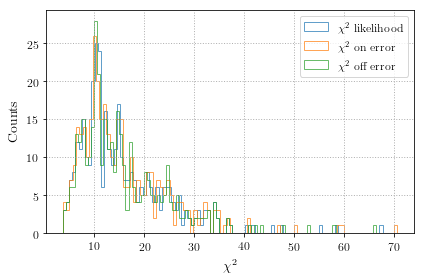

In [64]:
fig, ax = plt.subplots()
hist_params = {'bins': 100,
               'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results['chi2-likelihood'], label='$\\chi^2$ likelihood', **hist_params)
ax.hist(results['chi2-on'], label='$\\chi^2$ on error', **hist_params)
ax.hist(results['chi2-off'], label='$\\chi^2$ off error', **hist_params)
ax.set_xlabel('$\\chi^2$')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-chi2-calc-comparison.png'.format(config))
comp.check_output_dir(outfile)
# plt.savefig(outfile)

plt.show()

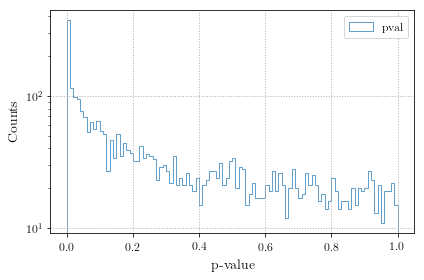

In [237]:
fig, ax = plt.subplots()
hist_params = {'bins': 100,
               'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results['pval'], **hist_params)
ax.set_xlabel('p-value')
ax.set_ylabel('Counts')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()
plt.show()

20.678665884206875


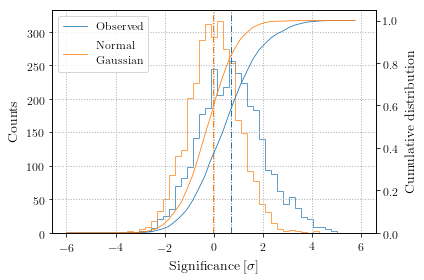

In [238]:
fig, ax = plt.subplots()
bins = np.linspace(-6, 6, 50)
hist_params = {'bins': bins,
               'histtype': 'step',
               'alpha': 0.7,
               }

theta, phi = hp.pix2ang(nside, results['pix_disc'])
ra, dec = healpy_to_equatorial(theta, phi)

# sig = results.loc[:, 'sig']
sig = results.loc[dec > np.deg2rad(-90) + radius, 'sig']

ax.hist(sig, **hist_params)
ax.axvline(sig.median(),
           marker='None', ls='-.', lw=1,
           label='Median')

counts, _ = np.histogram(sig, bins=bins)
counts = counts / counts.sum()
ax_cdf = ax.twinx()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Observed')
ax_cdf.set_ylabel('Cumulative distribution')
ax_cdf.set_ylim(bottom=0)

np.random.seed(2)
# normal_samples = np.random.normal(size=int(1e6))
normal_samples = np.random.normal(size=len(sig))
ax.axvline(np.median(normal_samples),
           marker='None', ls='-.', lw=1,
           label='Median', color='C1')
ax.hist(normal_samples, **hist_params)
counts, _ = np.histogram(normal_samples, bins=bins)
counts = counts / counts.sum()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Normal \n Gaussian' )


d, ks_pval = stats.ks_2samp(normal_samples, sig.values)
print(erfcinv(2 * ks_pval) * np.sqrt(2))


ax.set_xlabel('Significance [$\\sigma$]')
ax.set_ylabel('Counts')
ax.grid()
ax_cdf.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-significance-dist.png'.format(config))
plt.savefig(outfile)

plt.show()

Save map to disk

In [239]:
# hp.write_map('chi-squared-map.fits', chi2_map, dtype=chi2_map.dtype, coord='C')

In [240]:
# chi2_map = hp.read_map('chi-squared-map.fits')

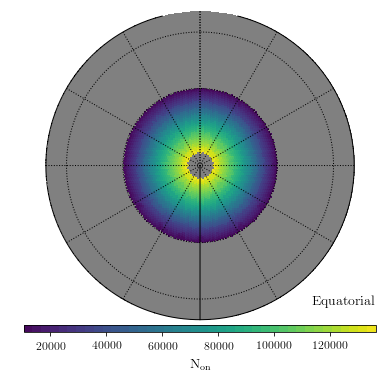

In [241]:
num_on_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
num_on_map[results['pix_disc']] = results['num_on']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
num_on_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(num_on_map, cbar_title='$\mathrm{N_{on}}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-num-on-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

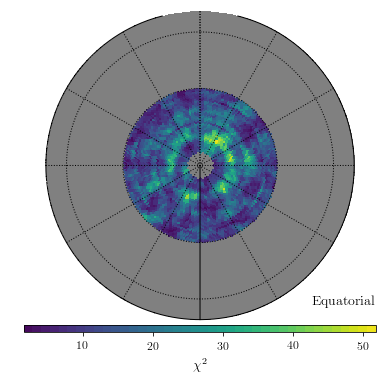

In [242]:
# chi2_map[chi2_map == 0] = hp.UNSEEN
# chi2_map = np.full(npix, hp.UNSEEN)

chi2_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
chi2_map[results['pix_disc']] = results['chi2-likelihood']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
chi2_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(chi2_map, cbar_title='$\mathrm{\chi^2}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-chi2-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

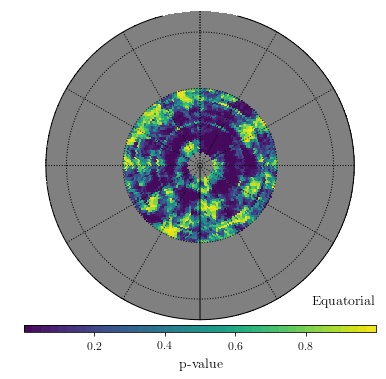

In [243]:
pval_map = np.full(npix, hp.UNSEEN)
pval_map[results['pix_disc']] = results['pval']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
pval_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(pval_map, cbar_title='p-value', polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-pval-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

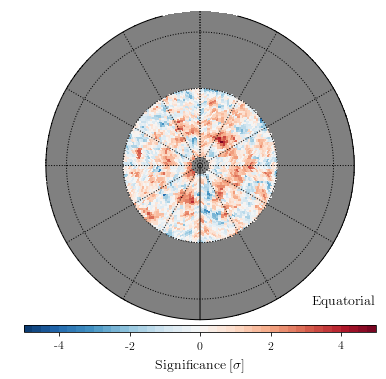

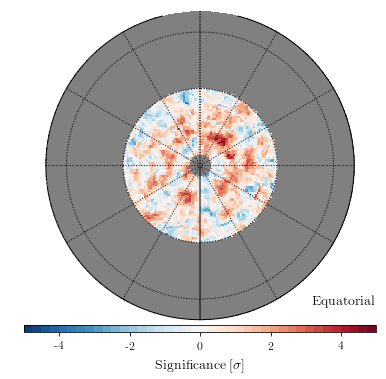

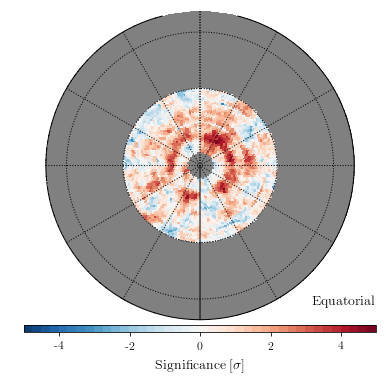

In [254]:
for r in [3.0, 4.0, 5.0]:
    input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(r))
    results = pd.read_hdf(input_hdf)

    sig_map = np.full(npix, hp.UNSEEN)
    sig_map[results['pix_disc']] = results['sig']

    theta, phi = hp.pix2ang(nside, range(npix))
    ra, dec = healpy_to_equatorial(theta, phi)
    sig_map[dec < np.deg2rad(-90) + np.deg2rad(r)] = hp.UNSEEN

    comp.plot_skymap(sig_map,
                     color_palette='RdBu_r',
                     cbar_min=-5, cbar_max=5,
                     cbar_title='Significance [$\sigma$]',
                     polar=True)

    outfile = os.path.join(comp.paths.figures_dir,
                           'skymaps',
                           'radius-{}-degrees'.format(r),
                           '{}-sig-skymap-polar.png'.format(config))
    plt.savefig(outfile)

    plt.show()

In [245]:
sig_map.max()

5.005907156818285

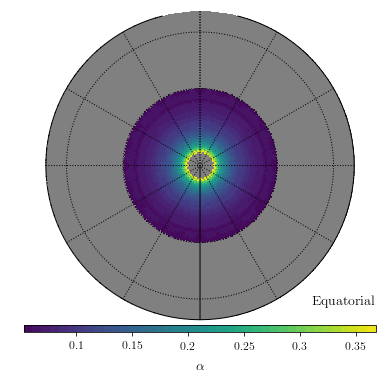

In [246]:
alpha_map = np.full(npix, hp.UNSEEN)
alpha_map[results['pix_disc']] = results['alpha']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
alpha_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(alpha_map, cbar_title='$\mathrm{\\alpha}$', polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-alpha-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [87]:
energy_mask = df_data.loc[:, 'reco_log_energy'] > 7.9
energy = df_data.loc[energy_mask, 'reco_log_energy']
ra = df_data.loc[energy_mask, 'lap_ra']
dec = df_data.loc[energy_mask, 'lap_dec']

theta, phi = equatorial_to_healpy(ra, dec)

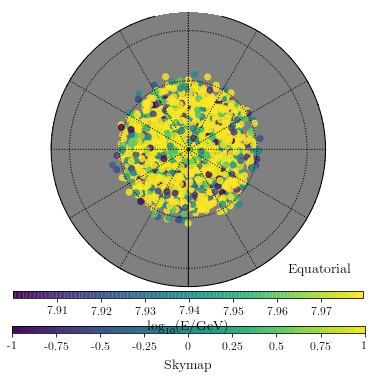

In [103]:
comp.plot_skymap(np.full(npix, hp.UNSEEN), polar=True)
fig = plt.gcf()
ax = plt.gca()

image = hp.projscatter(theta, phi, c=energy, alpha=0.8)
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
plt.show()